# **Multiclass classification for Stack Exchange Dataset using bert model handling longer sequences**

# **Set Up Environment**

In [2]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW7") # CHANGE BASED ON YOUR SETUP


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers.trainer_utils import EvalPrediction
from transformers import PreTrainedModel

import evaluate
from evaluate import load

from scipy.special import softmax
from scipy.special import logsumexp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import wandb
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import textwrap
import gc
from datasets.utils.logging import disable_progress_bar
from functools import partial

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [ ]:
disable_progress_bar()
data_folder = base_folder/'Data' # CHANGE BASED ON YOUR SETUP
model_folder = base_folder/'Models' # CHANGE BASED ON YOUR SETUP
model_folder.mkdir(exist_ok=True)

# **Function to Load Dataset - filtered for word length > 400**

In [ ]:
def load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=None):
    from datasets import load_dataset
    dataset = load_dataset('csv', data_files=str(data_path))
    selected_columns = {
    'text': dataset['train'][text_column_name],
    'label': dataset['train'][label_columns_name]
    }

    # Create a new dataset with the selected columns
    dataset_selected_columns = Dataset.from_dict(selected_columns)
    dataset_selected_columns.set_format(type='pandas')
    df = dataset_selected_columns[:]
    df['text'] = df['text'].fillna('')
    df['words_per_review'] = df['text'].str.split().apply(len)
    df = df[df['words_per_review'] > 400].copy()
    df.drop('words_per_review', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    dataset_selected_columns = Dataset.from_pandas(df) #converting the dataframe back to hugging face dataset

    if class_names:
        dataset_selected_columns = dataset_selected_columns.cast_column('label', ClassLabel(names = class_names))

    return dataset_selected_columns

# **Function for class weights to address imbalance in the dataset**

In [ ]:
def get_class_weights(train_dataset_full):
  train_dataset_full.set_format(type='pandas')
  df = train_dataset_full[:]
  class_weights = df['label'].value_counts(normalize=True, sort=False)
  class_weights = class_weights.sort_index()
    # 1. Compute the class frequencies:
  class_weights = df['label'].value_counts(normalize=True, sort=False)

  # 2. Sort weights by index (i.e., by label):
  class_weights = class_weights.sort_index()

  # 3. Compute the inverse of the class frequencies:
  class_weights = 1/class_weights

  # 4. Normalize the weights so they sum up to 1 (this step is optional but can be useful):
  class_weights = class_weights / class_weights.sum()

  # 5. Convert the weights to a PyTorch tensor:
  class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)
  return class_tensor_weights



# **Function to Split Dataset and also creates a small subset if the argument for small_subset is True**

In [ ]:
def split_dataset(dataset, train_size, val_size, test_size, small_subset=False, subset_size=None):
    train_val_splits = dataset.train_test_split(train_size=train_size, seed=42, stratify_by_column='label')
    train_split= train_val_splits['train']
    test_size_new =test_size/(test_size + val_size)
    test_val_splits = train_val_splits['test'].train_test_split(test_size=test_size_new, seed=42, stratify_by_column='label')
    val_split = test_val_splits['train']
    test_split = test_val_splits['test']

    train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})
    test_dataset = DatasetDict({'test': test_split})

    if small_subset:
      train_split_small = train_split.shuffle(seed=42).select(range(subset_size))
      val_split_small = val_split.shuffle(seed=42).select(range(subset_size))
      test_split_small = test_split.shuffle(seed=42).select(range(subset_size))
      train_val_small = DatasetDict({"train": train_split_small, "valid": val_split_small})
      test_small = DatasetDict({'test': test_split_small})
      return train_val_small, test_small


    return train_val_dataset, test_dataset

# **Function to Create smaller subset**

In [ ]:
def get_small_balanced_subset(dataset, num_samples_per_class):
    subset = DatasetDict()

    for split in list(dataset.keys()):
        texts = []
        labels = []
        for label in range(10):
            label_texts = dataset[split].filter(lambda x: x['label'] == label)['text']
            label_subset = random.sample(list(label_texts), num_samples_per_class)
            texts.extend(label_subset)
            labels.extend([label]*len(label_subset))

        subset[split] = Dataset.from_dict({'text': texts, 'label': labels})

    return subset

# **Function for Tokenization**

In [ ]:
def get_tokenized_dataset(checkpoint, dataset):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_fn(batch):
        # Debug print statements
        # print(f"Type of batch['text']: {type(batch['text'])}")
        # print(f"First item in batch['text']: {batch['text'][0]}")
        return tokenizer(batch["text"])

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)
    return tokenized_dataset

# **Function to Create Datasets**

In [ ]:
def setup_dataset(data_folder, class_names,subset_size,small_subset_bool):

    # Constants for loading and splitting
    data_path = data_folder / 'multiclass_hw_basic_clean.csv'
    label_columns_name = 'Tag_Number_final'
    text_column_name = 'basic_cleaned_text'

    # 1. Load Dataset
    dataset = load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=class_names)

    # 2. Split Dataset
    train_val_dataset, test_dataset = split_dataset(dataset, train_size=0.6, val_size=0.2, test_size=0.2, small_subset=small_subset_bool, subset_size = subset_size)


    return train_val_dataset, test_dataset

# **Function for tokenization**

In [ ]:
#collate function
def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item['text'] for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result

# **Function to Initialize Model**

In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    return model

# **Function to aggregate predictions (average of log probabilities) and evaluation --> compute metrics**

In [ ]:
def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax

In [ ]:
#aggregate predictions***************************************************
def aggregate_predictions (logits, aggregation_method, overflow_to_sample_mapping):

    probabilities = softmax(logits, axis=-1)
    log_probabilities = stable_log_softmax(logits)

    # print('log_probs', log_probabilities.shape)
    # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

    # Get unique documents

    unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
    num_docs = unique_docs.size

    # Create a mask for documents
    mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

    # Initialize the aggregated_predictions variable
    aggregated_predictions = None

    if aggregation_method == "average_log_probs":
        # Compute average probabilities using NumPy
        avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
        scores = np.exp(avg_log_probs.max(axis=-1))

    elif aggregation_method == "average_probs":
        # Compute average probabilities using NumPy
        avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_probs, axis=-1)
        scores  = avg_probs.max(axis=-1)

    elif aggregation_method == "max_probs":
        # Compute max probabilities per document
        max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
        max_log_probs = np.max(max_values, axis=0)
        aggregated_predictions = np.argmax(max_log_probs, axis=-1)
        scores = np.exp(max_log_probs.max(axis=-1))

    elif aggregation_method == "majority_vote":
        # Convert logits to actual predictions before voting
        predictions = np.argmax(logits, axis=1)
        # Tally the votes for each document
        vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
        np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
        # Determine the majority vote for each document
        aggregated_predictions = np.argmax(vote_tally, axis=1)
        scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
    else:
        raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

    return aggregated_predictions, scores

In [ ]:
#evaluate function*************************************************************************
def evaluate_model(dataloader: DataLoader,
                   model: PreTrainedModel,
                   metric_only: bool = True,
                   aggregation_method: str ='average_log_probs'):
    # Load the accuracy metric
    accuracy_metric = load("accuracy")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)

    predictions = []
    all_doc_labels = []

    # Loop over batches
    for batch in dataloader:
        model.eval()
        doc_labels = batch.pop("doc_labels", None).cpu().numpy()
        overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits.cpu().numpy()
            aggregated_predictions, scores = aggregate_predictions(logits=logits,
                                                            aggregation_method=aggregation_method,
                                                            overflow_to_sample_mapping=overflow_to_sample_mapping)

            accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            if not metric_only:
                predictions.extend(aggregated_predictions)
                all_doc_labels.extend(doc_labels)

    # Calculate and return the final accuracy.
    final_accuracy = accuracy_metric.compute()['accuracy']

    if metric_only:
        return final_accuracy
    else:
        return final_accuracy, predictions, all_doc_labels

# **Function to set Trainer**

In [ ]:
#custom trainer*****************************************************************
class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs",**kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type
        #taking care of imbalance in the dataset
        self.nll_loss = nn.NLLLoss(weight=class_tensor_weights.to(model.device))


    def compute_loss(self, model, inputs, return_outputs=False):

        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # print(logits)

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)



        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]


        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = self.nll_loss(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "average_probs":
            avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            avg_log_probs = torch.log(avg_probs)
            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = self.nll_loss(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "max":
            max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
            max_log_probs = max_values.max(dim=0).values
            # print('max_log_probs_shape', max_log_probs.shape)
            loss = self.nll_loss(max_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "loss_per_chunk":
            # print('log_probs_shape', log_probabilities.shape)
            loss = self.nll_loss(log_probabilities, labels.view(-1))
            # print(loss)

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")


        return (loss, logits) if return_outputs else loss

In [ ]:
def get_trainer(model, training_args, train_dataset, eval_dataset, tokenizer, data_collator):
    trainer = CustomTrainer(
        loss_type = "average_log_probs",
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator= data_collator
    )
    return trainer

# **Function to plot confusion matrix**

In [ ]:
def plot_confusion_matrix(actuals,predictions,class_names):

  cm = confusion_matrix(actuals, predictions,normalize='true')

  # Plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  # Ensure x-labels are vertical
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # Ensure y-labels are horizontal
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

# **Function to free memory**

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# **Function to tokenize dataset and, train and eval models**

In [ ]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_dataset):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course_fall_2023-HW7-Part-B-Colab

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder / "Models"
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_dataset)

    # 4. Initialize Model and Tokenizer
    global model
    model = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 256)

    # 5. Initialize Trainer

    global class_tensor_weights
    class_tensor_weights = get_class_weights(train_val_dataset['train'])
    trainer = get_trainer(model= model,
                          training_args= training_args,
                          train_dataset= train_val_tokenized_dataset['train'],
                          eval_dataset = train_val_tokenized_dataset['valid'],
                          tokenizer= tokenizer,
                          data_collator=collate_fn)

    # 6. Train and Evaluate
    trainer.train()
    val_accuracy, val_predictions, val_labels = evaluate_model(
                              trainer.get_test_dataloader(train_val_dataset['valid']),
                              model, metric_only=False)



    # 7. Log Metrics and Plot
    plot_confusion_matrix(val_labels,val_predictions,class_names=class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

# **Initial Training Arguments**

In [ ]:
from transformers import TrainingArguments

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,
    gradient_checkpointing=True,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=1,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=1,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Use 'accuracy' as the metric to determine the best model
    # metric_for_best_model="accuracy",
    # greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=1,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='stack_exchange_long_seq_trunc',  # Experiment name for Weights & Biases
)

# **Experiments**

# **Dataset hyperparameters**

In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']
subset_size = 500
train_val_dataset, test_dataset = setup_dataset(data_folder, class_names,subset_size=subset_size,small_subset_bool=True)


In [ ]:
train_val_dataset, test_dataset

(DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 500
     })
     valid: Dataset({
         features: ['text', 'label'],
         num_rows: 500
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 500
     })
 }))

# **Experiment 1 :**

- per_device_eval_batch_size=8,

- per_device_train_batch_size=8,

- gradient_accumulation_steps=2,

- resulting in an effective batch size of 16.

In [ ]:
checkpoint = 'bert-base-uncased'
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{subset_size}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)
new_training_args

In [ ]:
free_memory()

wandb: Currently logged in as: poojaakkaladevi98 (pooja_rocks98). Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-HW7-Part-B-Colab


Token indices sequence length is longer than the specified maximum sequence length for this model (1768 > 512). Running this sequence through the model will result in indexing errors
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,2.406200,2.323739
2,2.297500,2.319509
3,2.169600,2.320425
4,2.412400,2.312533
5,2.387700,2.297469
6,2.367100,2.288421
7,2.287100,2.284492
8,2.304800,2.280656
9,2.257400,2.275803
10,2.262300,2.271503


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

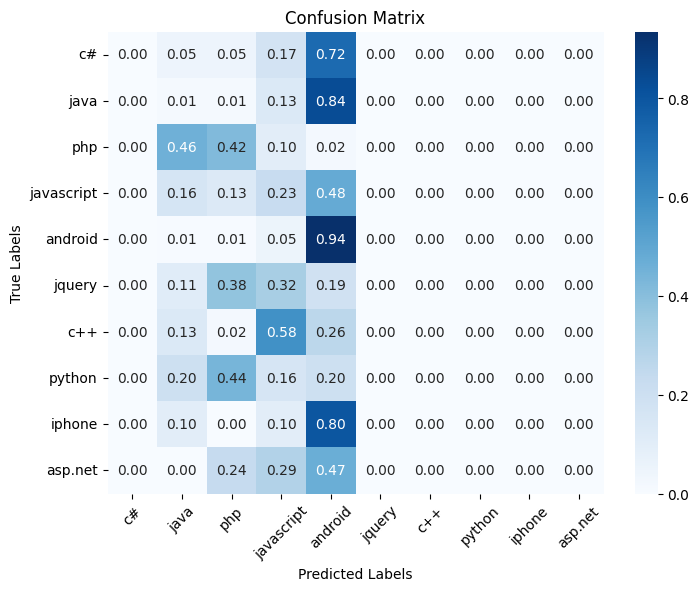

The best model was saved at step 23.


eval/loss,███▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▃▄▅▆▆▆▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇█▇█████
eval/samples_per_second,█▆▅▄▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
eval/steps_per_second,█▆▅▄▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/loss,█▅▂█▇▇▅▅▄▄▄▆▄▄▅▆▆▄▇▃▁▂▂▄▆▇▂▄▇▆▆
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args,
                            checkpoint=checkpoint,
                            base_folder=base_folder,
                            class_names=class_names,
                            train_val_dataset=train_val_dataset,
                             )

# **Experiment 2 :**

- per_device_eval_batch_size=8,

- per_device_train_batch_size=8,

- gradient_accumulation_steps=4,

- resulting in an effective batch size of 32.

In [ ]:
checkpoint = 'bert-base-uncased'
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['gradient_accumulation_steps'] = 4
training_args_dict['run_name'] = f'{checkpoint}-{subset_size}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)
new_training_args


env: WANDB_PROJECT=nlp_course_fall_2023-HW7-Part-B-Colab


Token indices sequence length is longer than the specified maximum sequence length for this model (1768 > 512). Running this sequence through the model will result in indexing errors
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,2.323500,2.327585
2,2.319600,2.324548
3,2.337400,2.309241
4,2.256600,2.296560
5,2.281100,2.298241
6,2.343100,2.299202
7,2.252500,2.296645
8,2.294800,2.290130
9,2.306000,2.282197
10,2.368500,2.275185


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

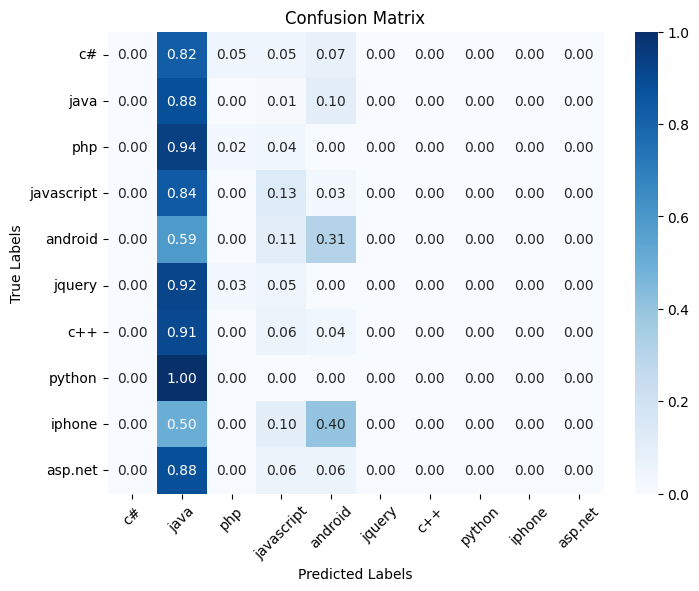

The best model was saved at step 15.


eval/loss,██▆▅▅▅▅▄▃▃▂▂▁▁▁
eval/runtime,▁▃▄█▇▆▅▆▆▅▆▆▇▇▇
eval/samples_per_second,█▆▅▁▂▃▄▃▃▄▃▂▂▂▂
eval/steps_per_second,█▆▅▁▂▃▄▃▃▄▃▃▂▂▂
train/epoch,▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,▅▅▆▂▃▇▂▄▅█▁▆▅▇▆
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args,
                            checkpoint=checkpoint,
                            base_folder=base_folder,
                            class_names=class_names,
                            train_val_dataset=train_val_dataset,
                             )

**Conclusion:**

- Due to my limited use of the entire dataset for training, we observe significantly low values along the diagonal of the confusion matrix.

- Due to a shortage of resources, specifically GPU availability, I opted for a sample size of 500 for training the model. This limitation is a contributing factor to the observed low accuracy.

In [1]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [3]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW7/Pooja_Akkaladevi_HW7_PartB.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW7/Pooja_Akkaladevi_HW7_PartB.ipynb to pdf
[NbConvertApp] Support files will be in Pooja_Akkaladevi_HW7_PartB_files/
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_PartB_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_PartB_files
[NbConvertApp] Writing 145981 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 229159 bytes to /content/drive/MyDrive/Pooja_HP_Singh_Projects/NLP/HW7/Pooja_Akkaladevi_HW7_PartB.pdf
